# Autoencoders


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from models import ConvEncoder, ConvDecoder
from training import train_epoch, val_epoch

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep


## Dataset and Dataloader

In [3]:
### Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor()
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor()
                             ]))

# Divide data dataset in train dataset and val dataset

train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

/home/alberto/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
### Dataloaders
batch_size = 100

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)



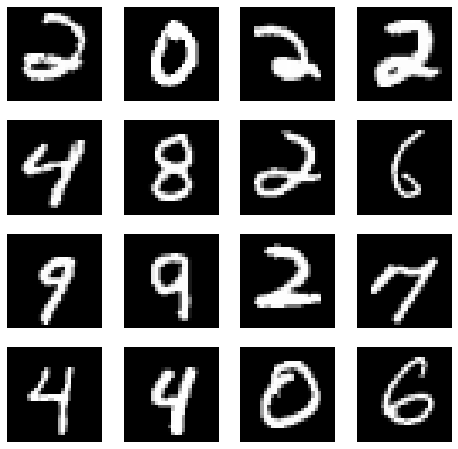

In [5]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Define the Network

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = ConvEncoder(encoded_space_dim=encoded_space_dim)
decoder = ConvDecoder(encoded_space_dim=encoded_space_dim)

### Move to device
encoder.to(device)
decoder.to(device)

# Training

In [ ]:
# Define the loss function
loss_function = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

# Define the optimizers
optimizer_1 = optim.Adam(params_to_optimize, lr = lr, weight_decay = 1e-5)
optimizer_2 = optim.SGD(params_to_optimize, lr = lr, momentum = 1.4, weight_decay = 0.1)

### Training loop with progress bar

num_epochs = 50


train_loss_log = []
val_loss_log = []

pbar = tqdm_notebook(range(num_epochs))

for epoch_num in pbar:
    
    # Train an epoch and save losses
    train_epoch_loss = train_epoch(encoder, decoder, device, train_dataloader, loss_function, optimizer_1)
    # Validate an epoch
    val_epoch_loss = val_epoch(encoder, decoder,  device, val_dataloader, loss_function)
    # Compute averages over an epoch
    mean_train_loss = np.mean(train_epoch_loss)
    mean_val_loss = np.mean(val_epoch_loss)
    # Append to plot
    train_loss_log.append(mean_train_loss)
    val_loss_log.append(mean_val_loss)
    pbar.set_description("Train loss: %s" %round(mean_train_loss,3)+","+"Validation loss %s" %round(mean_val_loss,3))
    
    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_data[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch_num + 1))
    plt.show()
    plt.close()
    
    sleep(0.03)
    pbar.update()

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load model

In [ ]:
### Save network parameters
### Save the network state
# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')

In [ ]:
### Reload the network state
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

# Network analysis

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

# Scatter plot
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# Reconstruct images
# Get the output of a specific image (the test image at index 0 in this case)
img_indx =10
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]
encoder.eval()
decoder.eval()
with torch.no_grad():
    rec_img  = decoder(encoder(img))
    
# Plot the reconstructed image
fig, axs = plt.subplots(3, 2, figsize=(18,9))
axs[0,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,0].set_title('Original image: label %d' %label)
axs[0,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,1].set_title('Reconstructed image')
plt.tight_layout()



In [ ]:
### Generate samples from encoded space
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-31, 11]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

In [ ]:
### Generate regular samples from encoded space

figure = plt.figure(figsize=(16, 16))
cols, rows = 15, 15

dim1 = np.linspace(-5,5,cols)
dim2 = np.linspace(-5,5,rows)

for i in range(cols):
    for j in range(rows):
        # Create  an encoded sample
        encoded_sample = [dim1[i], dim2[j]]
        encoded_sample = torch.tensor(encoded_sample).float().unsqueeze(0).to(device)
        
        # Decode sample
        decoder.eval()
        with torch.no_grad():
            generated_img  = decoder(encoded_sample)
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, label = train_data[sample_idx]
        figure.add_subplot(rows, cols, j*cols+1+i)
        plt.axis("off")
        plt.imshow(generated_img.squeeze().cpu().numpy(), cmap="gray")
plt.show()

# Denoising Autoencoder

In [6]:
### Define the noising function

class AddNoise(object):
    """
    Add Gaussian noise with given standard deviation to Mnist images
    """
    def __init__(self, std = 1.):
        self.std = std
        
    def __call__(self, img):
        return img+torch.randn_like(img)*self.std
        

In [21]:
### Define noise function
noise = AddNoise(std = 1.)

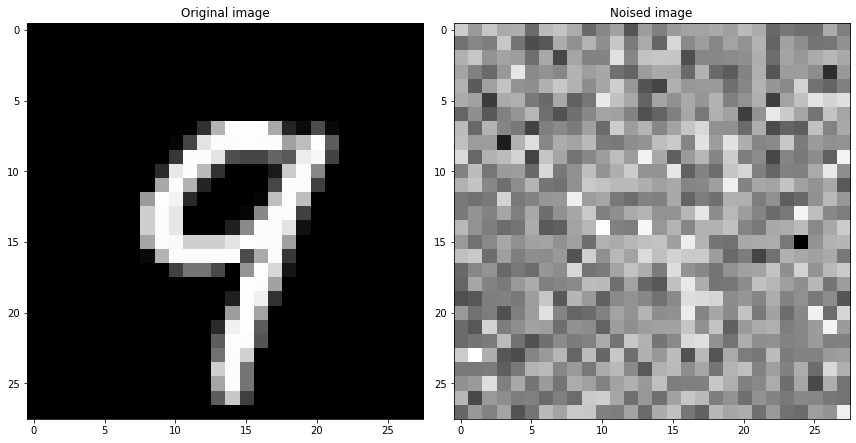

In [26]:
### Plot image and noised version

img_indx = 12
img = test_data[img_indx][0]

noised_img = noise(img)


# Plot the reconstructed image
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img.squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(noised_img.squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Noised image')
plt.tight_layout()

# Define the Network

In [13]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 10
encoder = ConvEncoder(encoded_space_dim=encoded_space_dim)
decoder = ConvDecoder(encoded_space_dim=encoded_space_dim)

### Move to device
encoder.to(device)
decoder.to(device)

Training device: cuda


ConvDecoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Training

  0%|          | 0/50 [00:00<?, ?it/s]

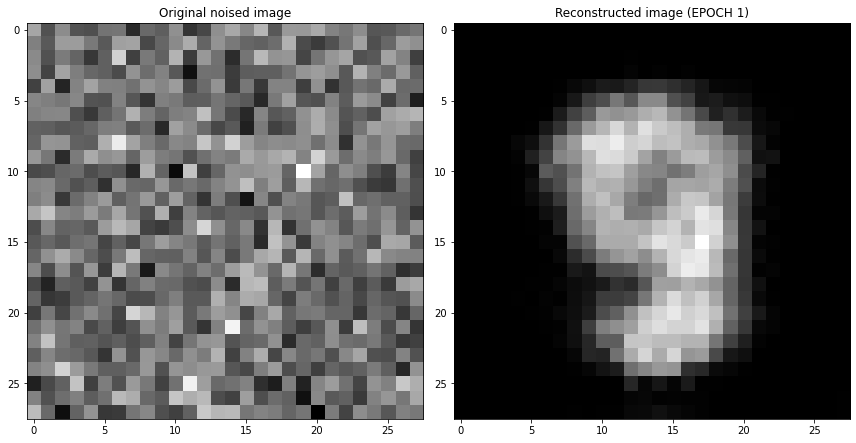

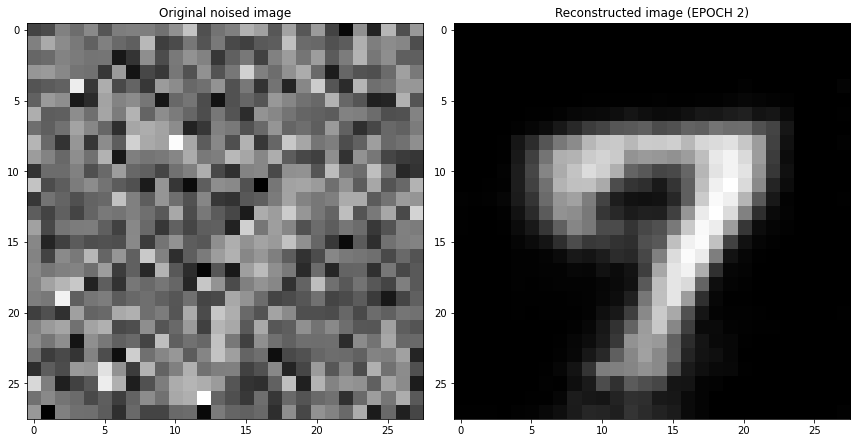

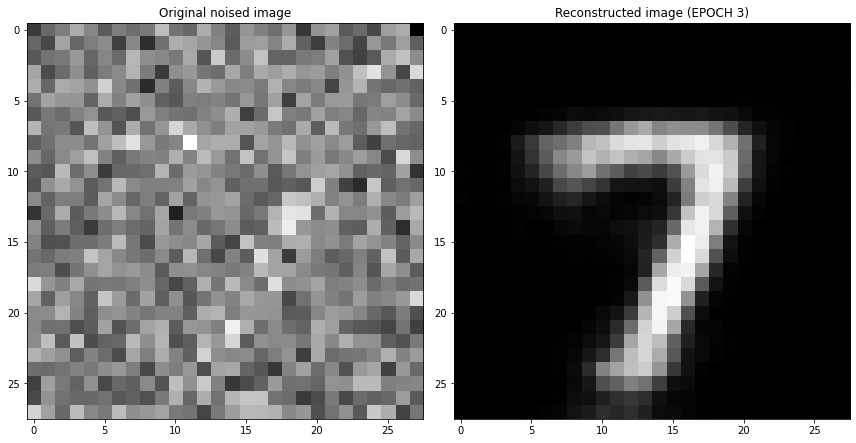

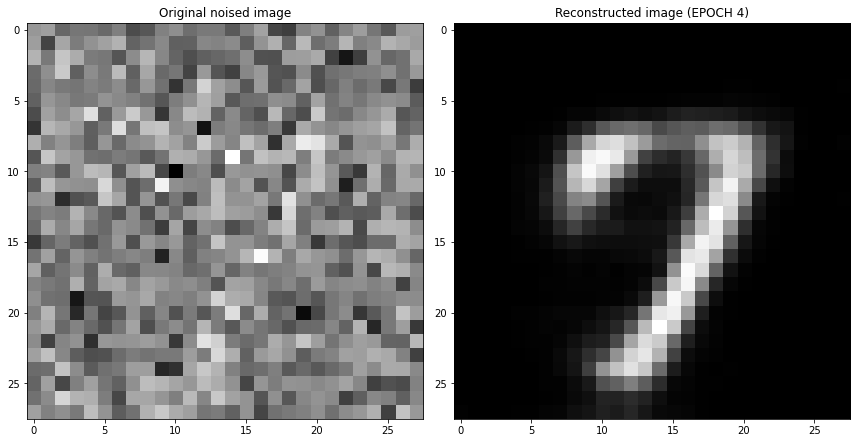

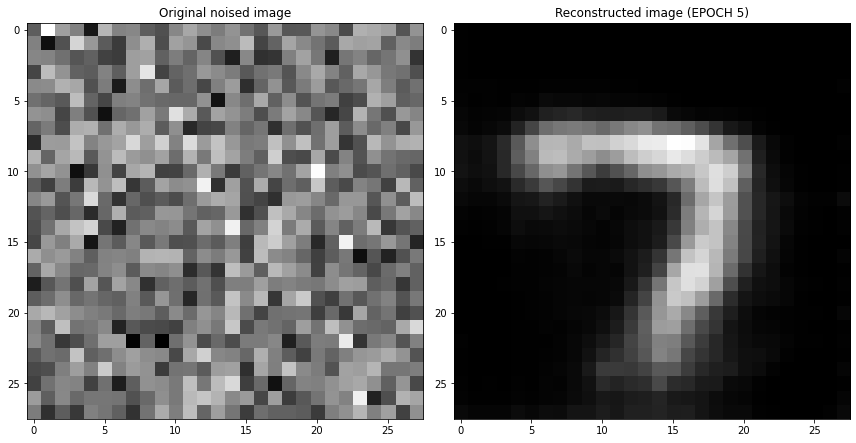

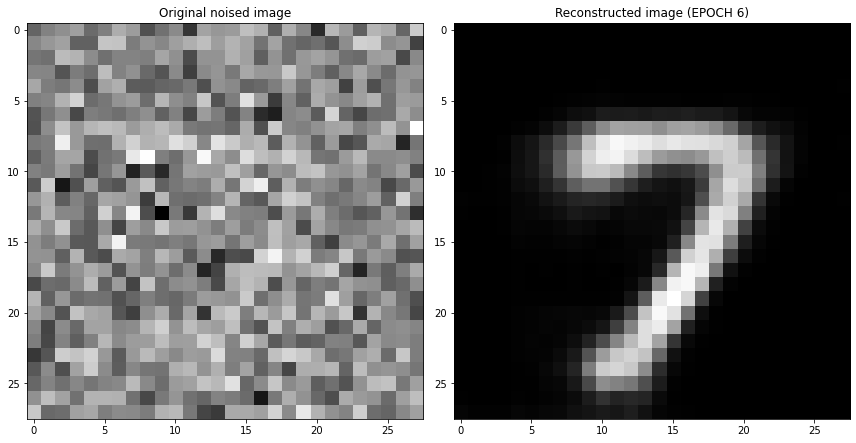

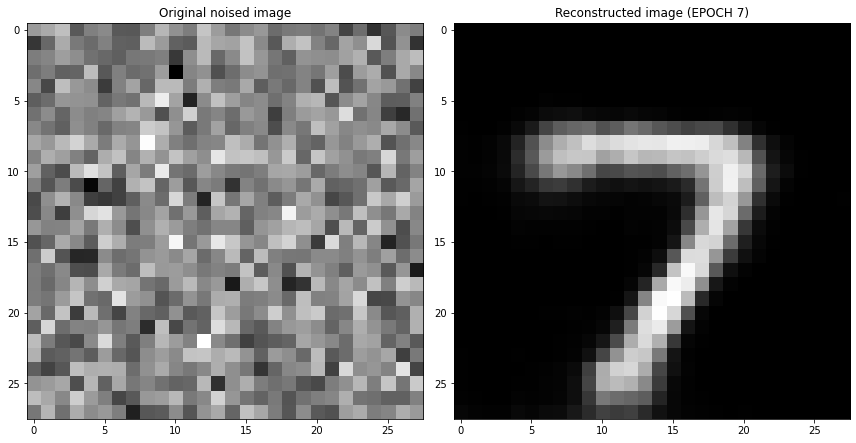

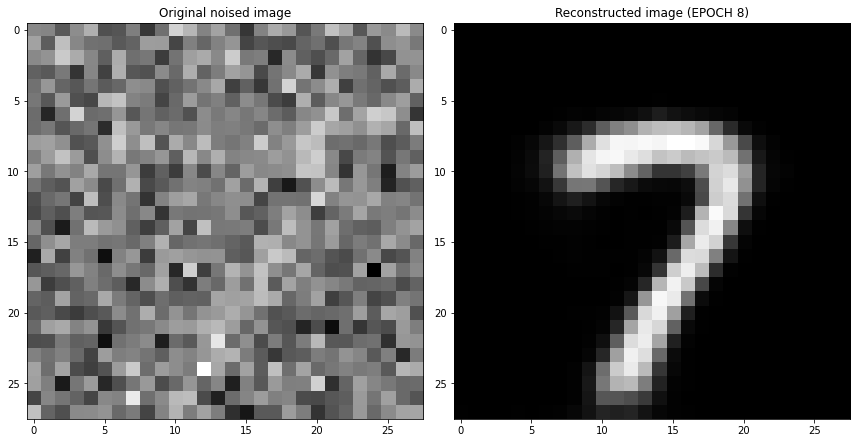

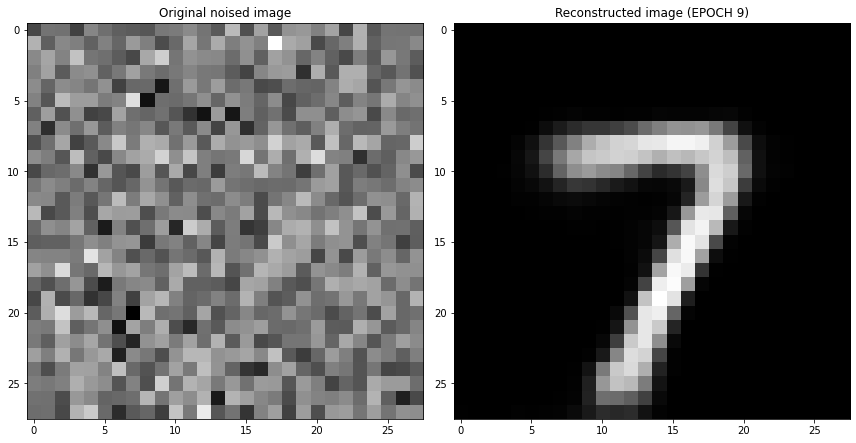

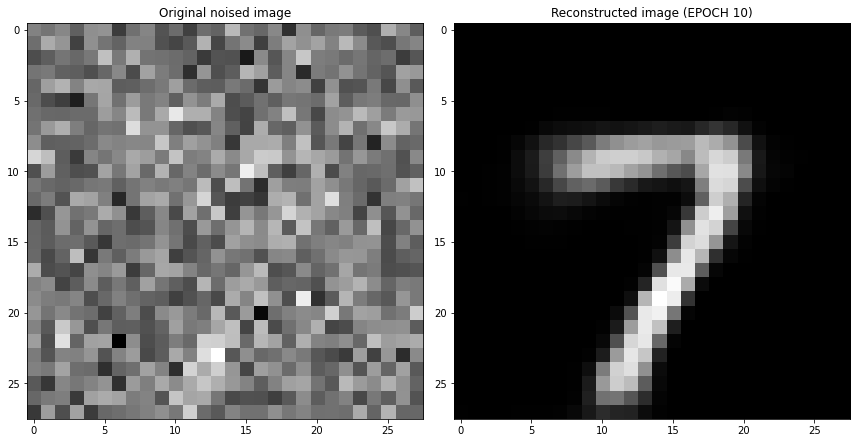

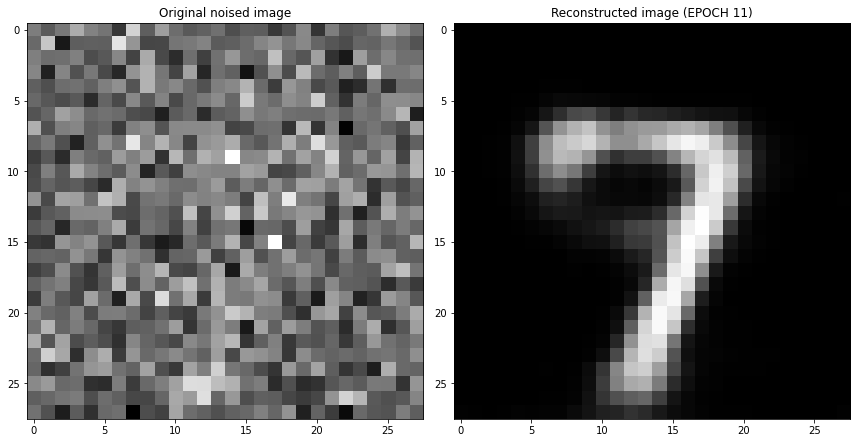

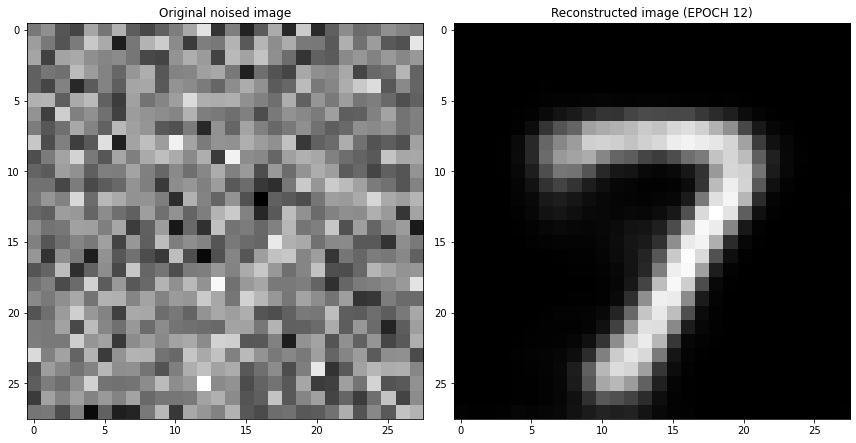

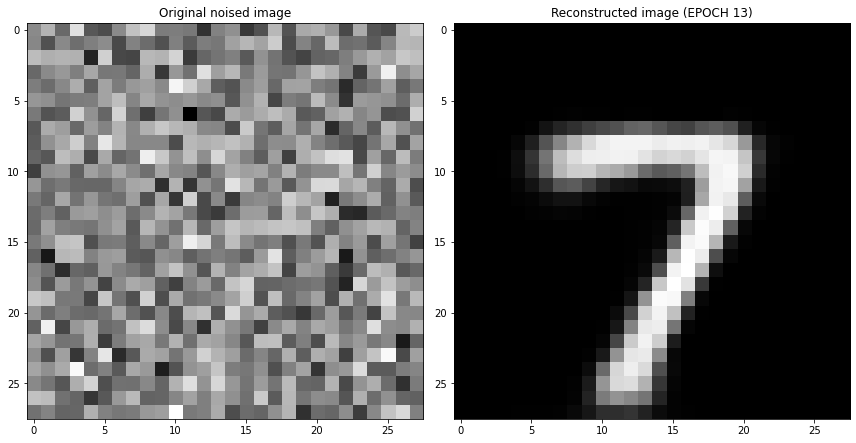

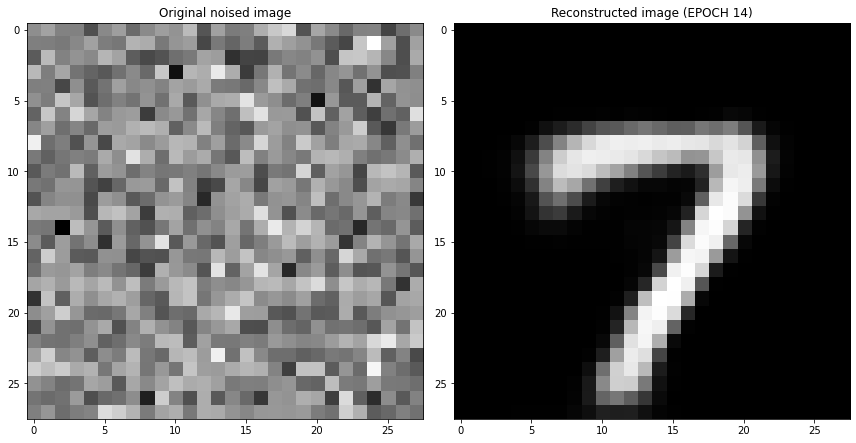

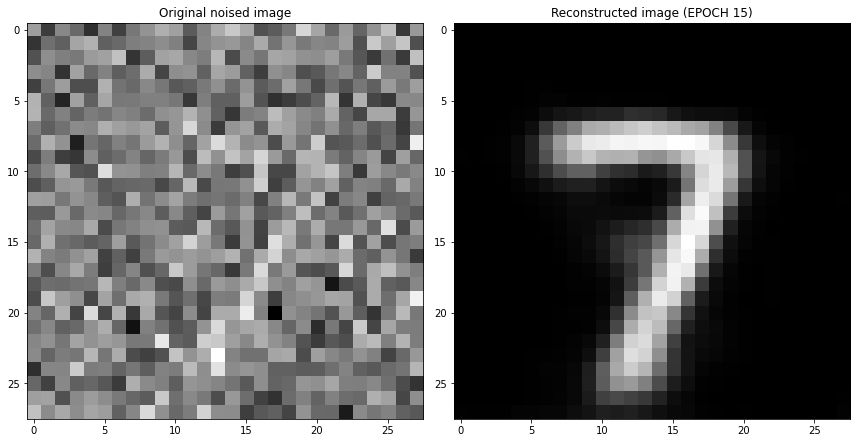

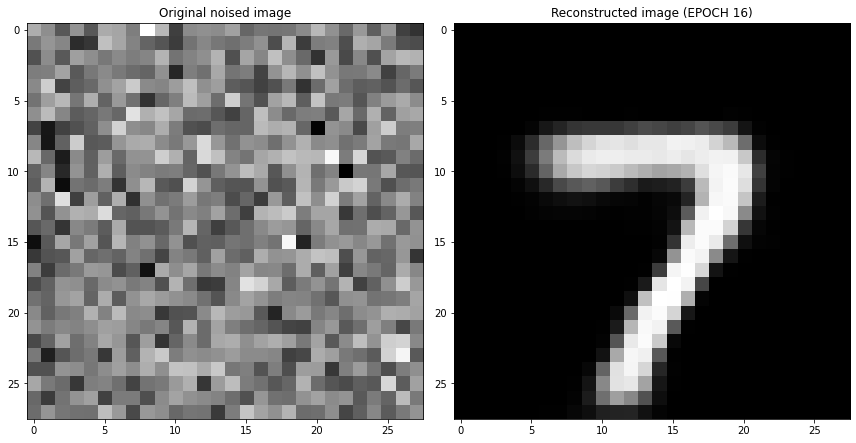

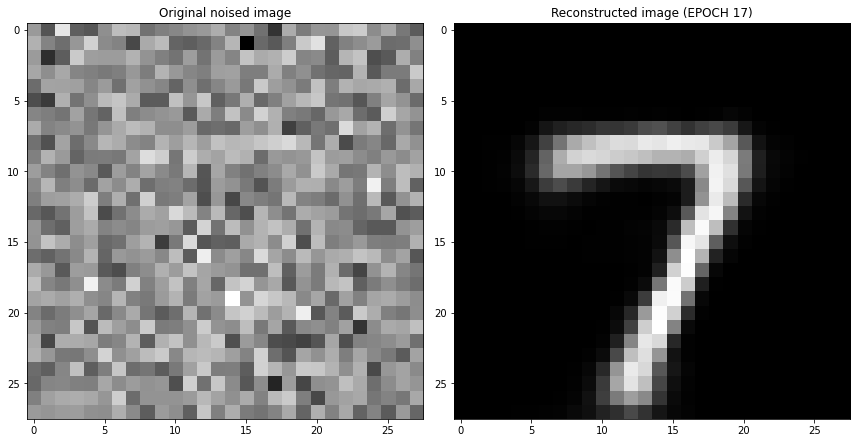

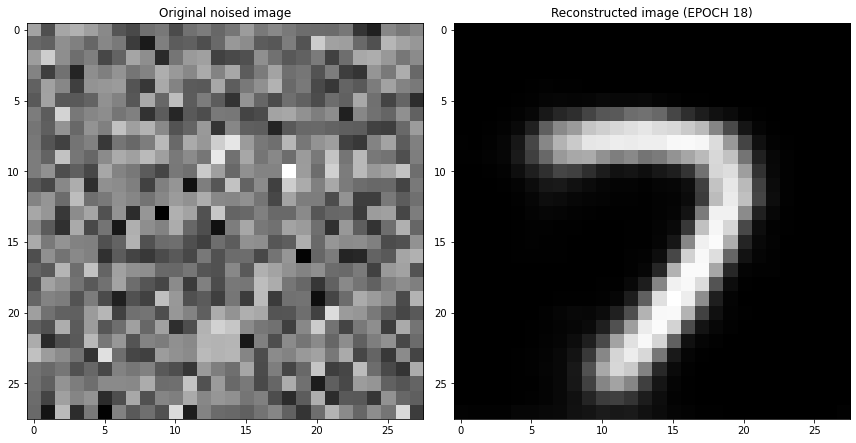

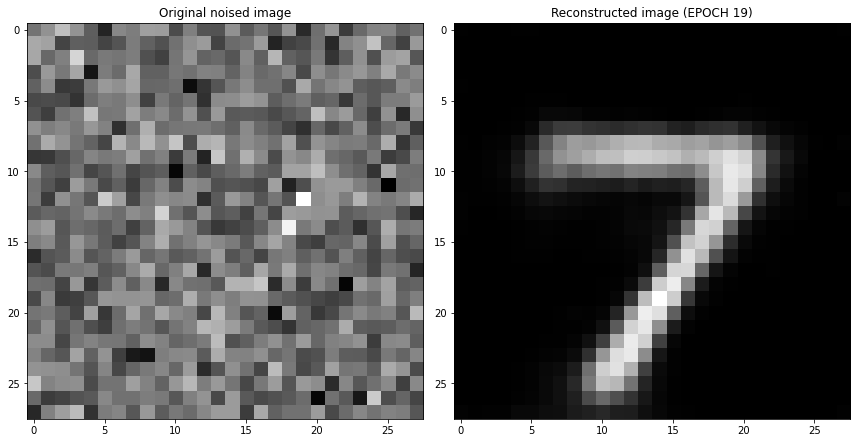

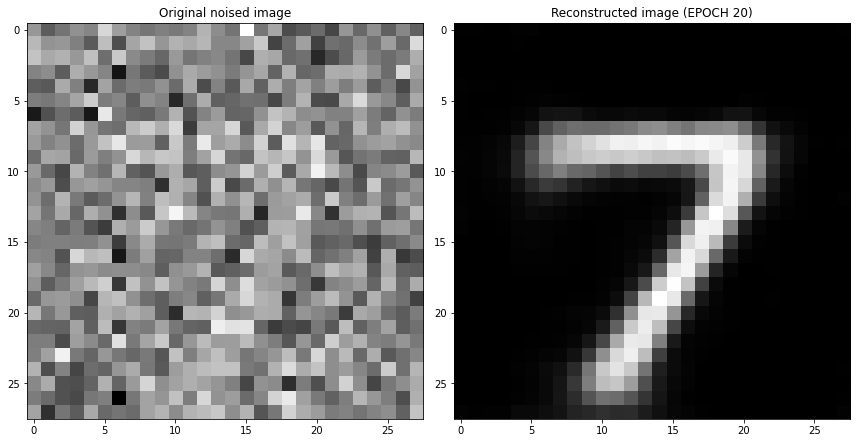

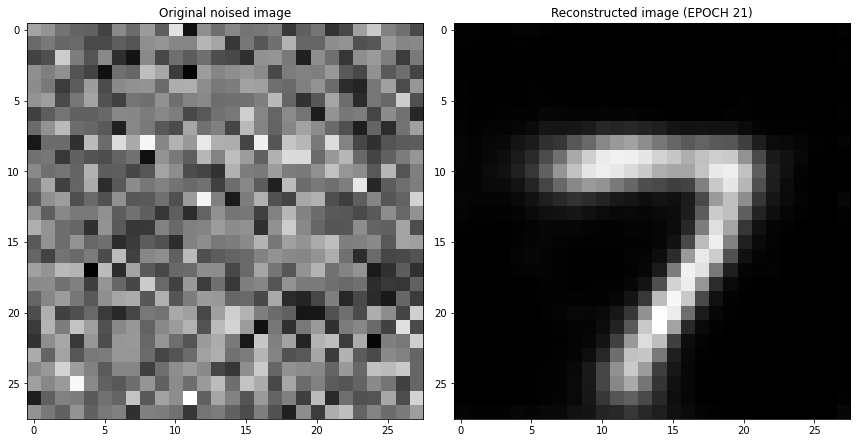

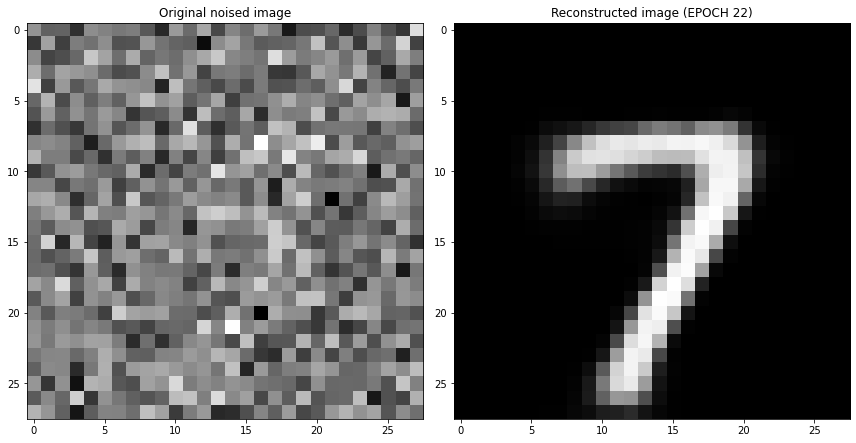

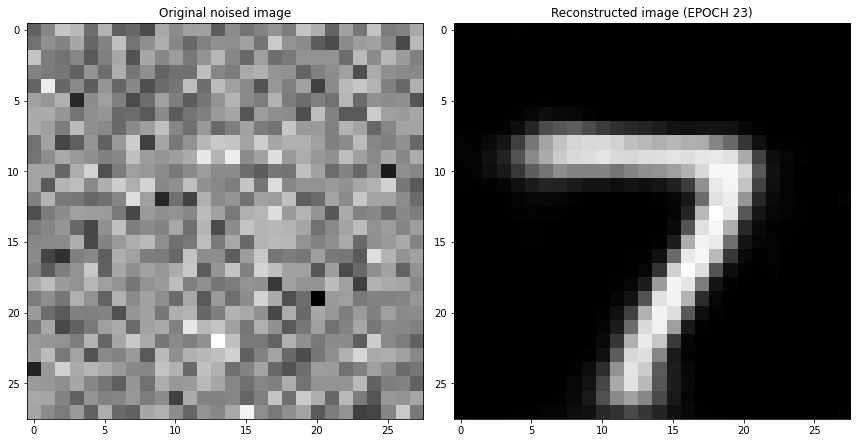

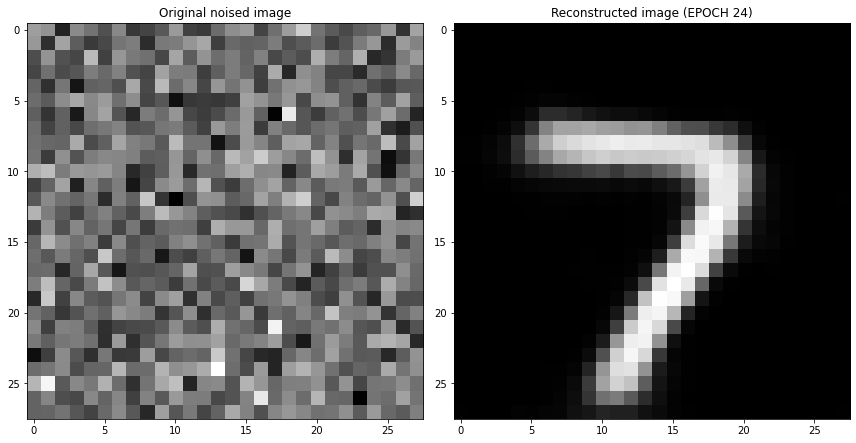

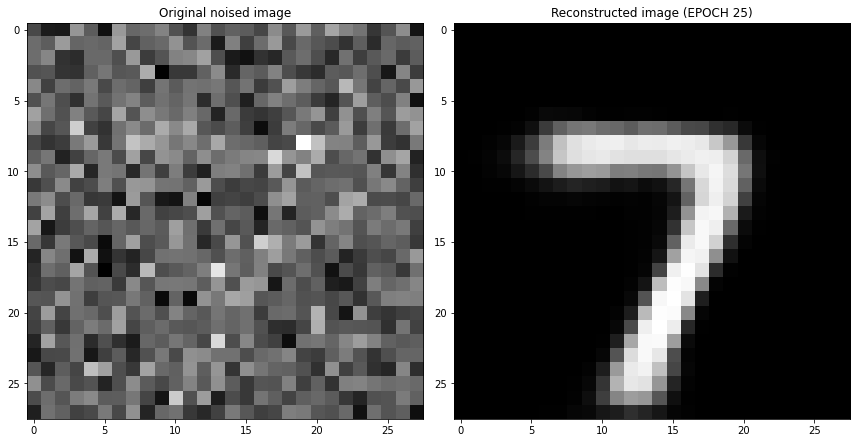

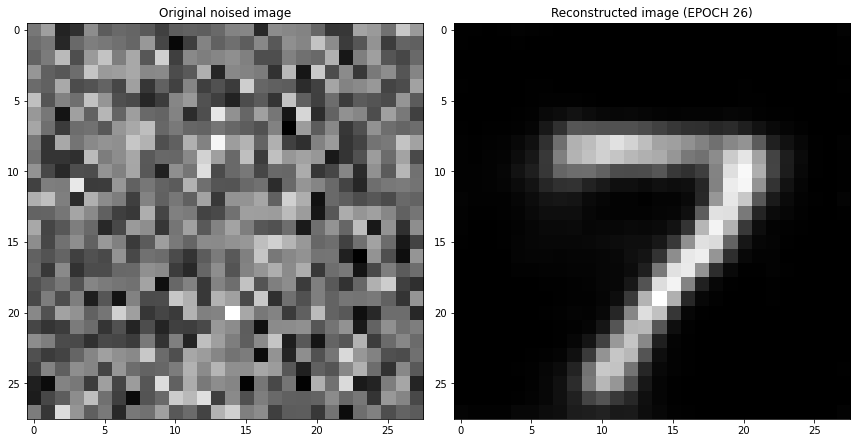

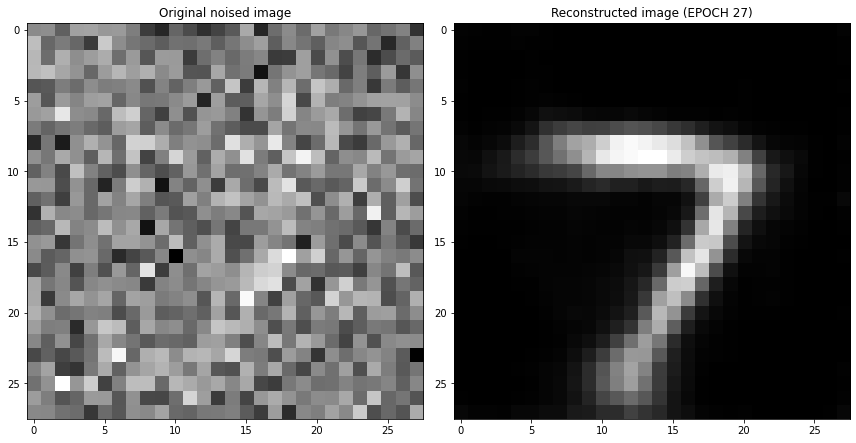

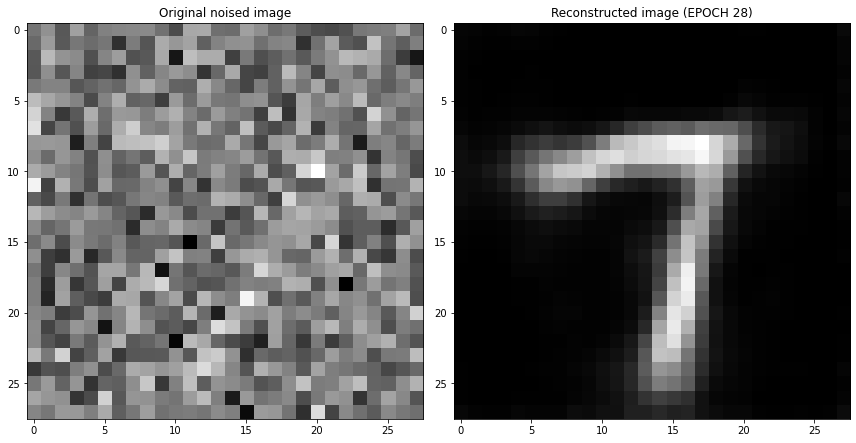

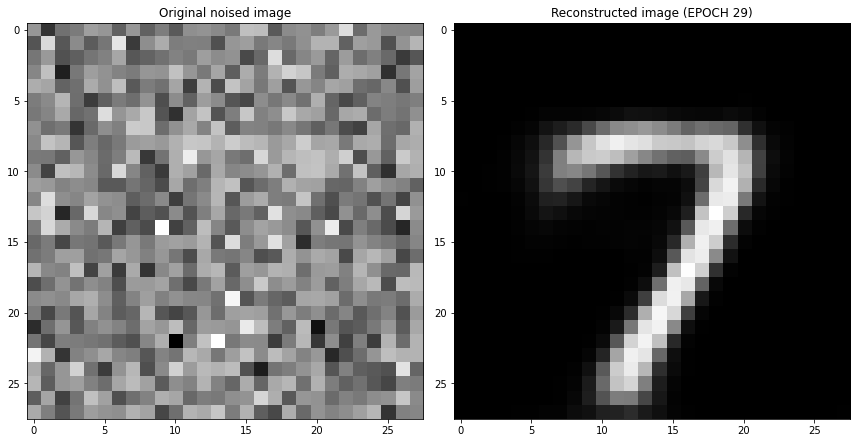

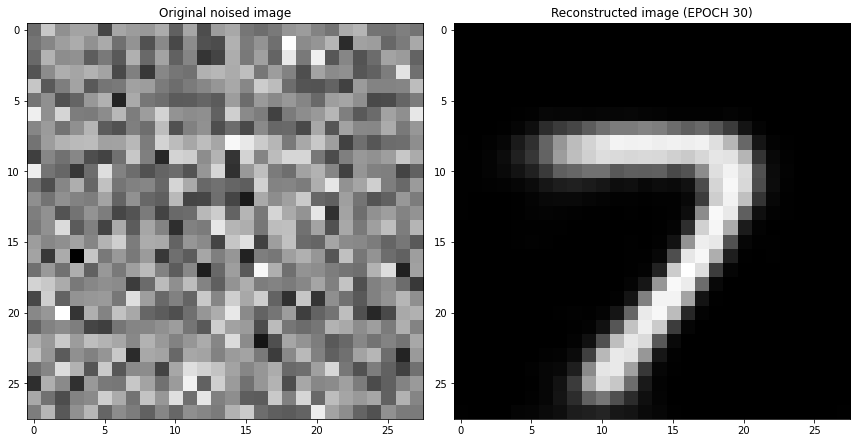

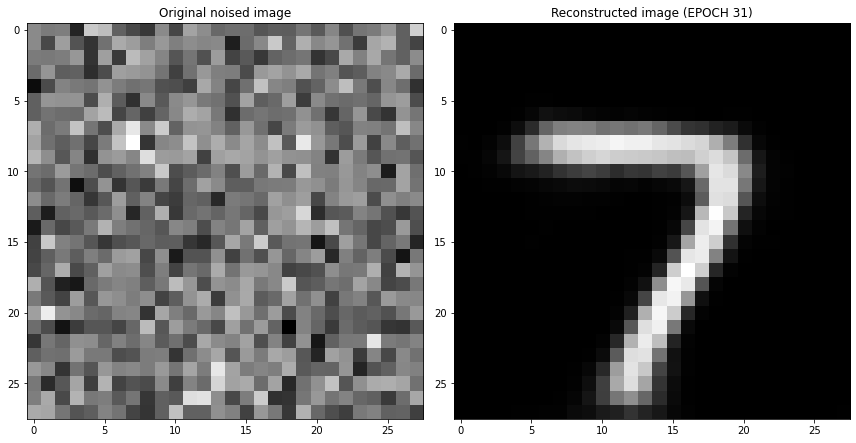

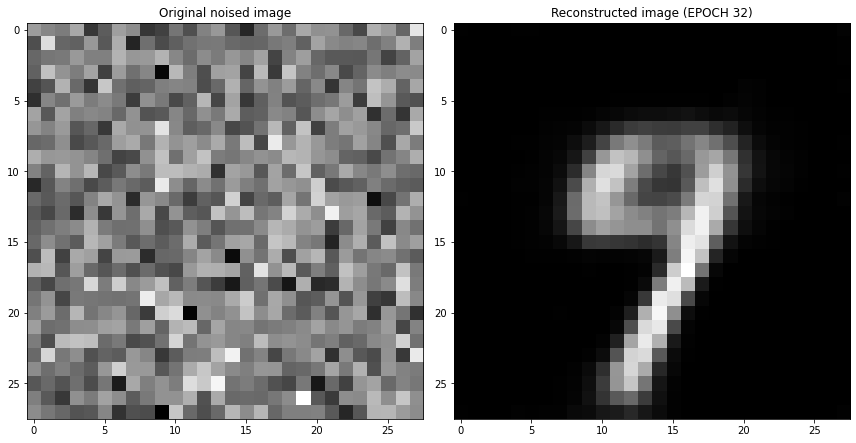

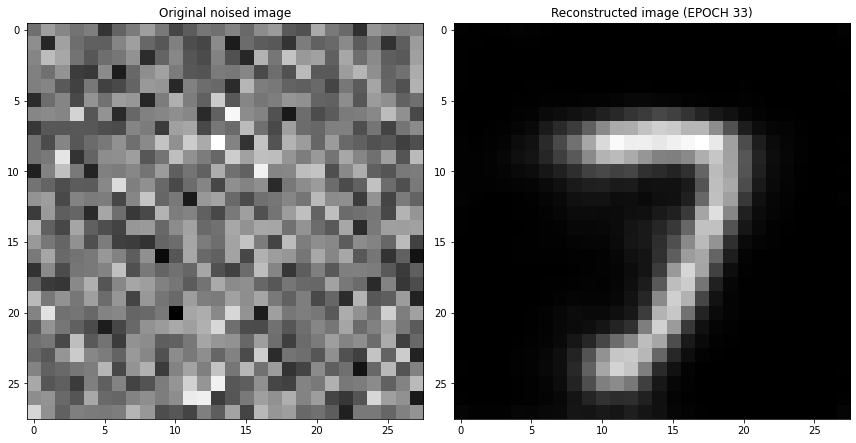

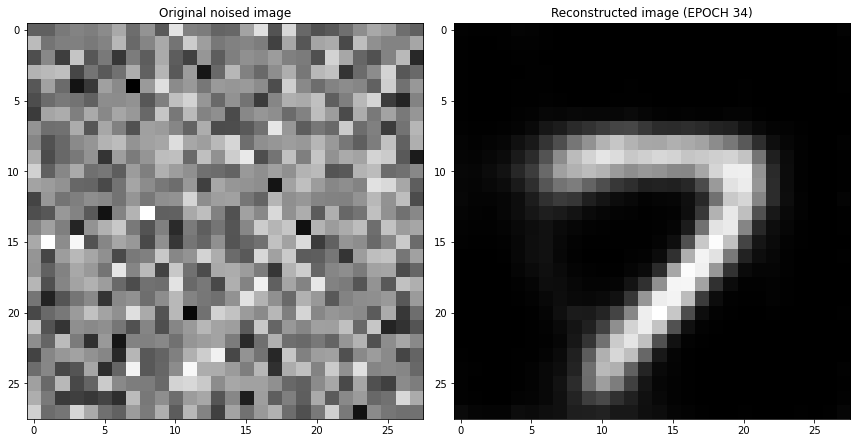

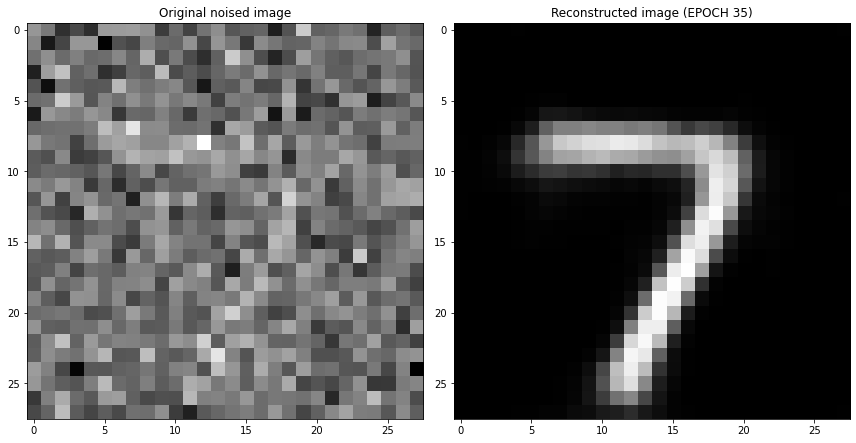

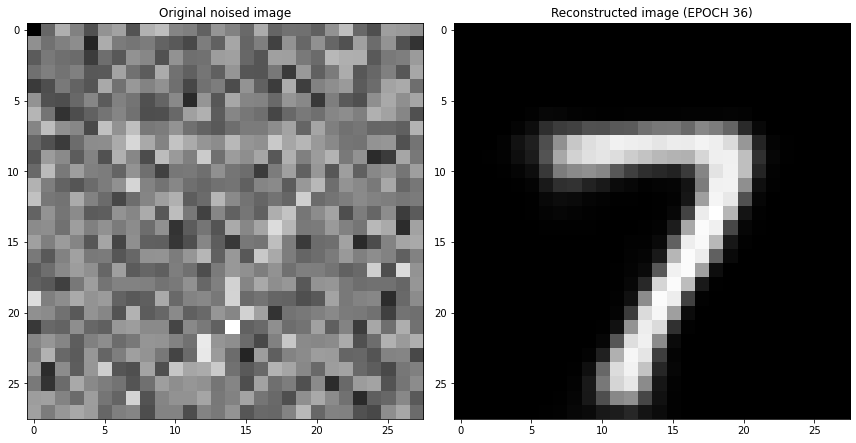

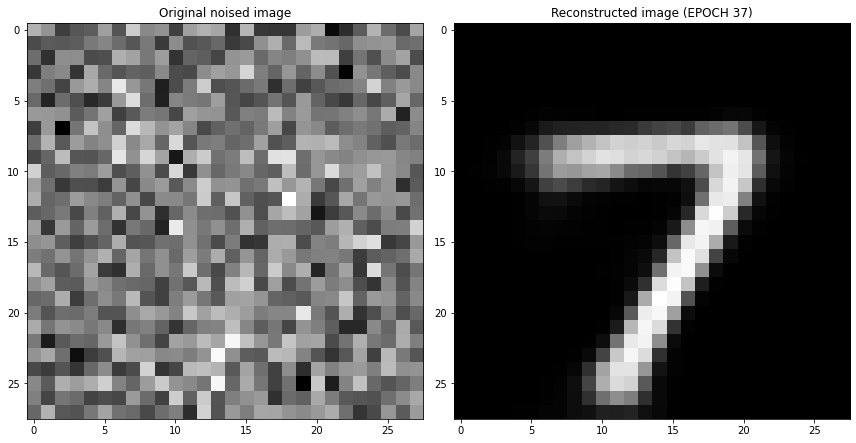

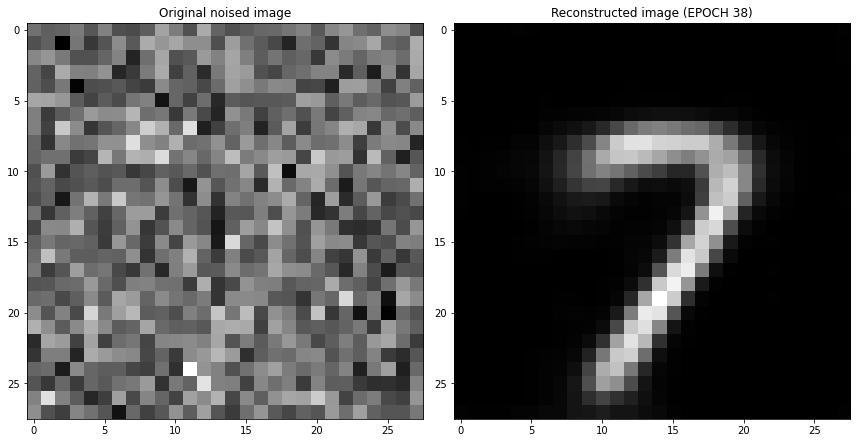

KeyboardInterrupt: 

In [14]:
# Define the loss function
loss_function = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

# Define the optimizers
optimizer_1 = optim.Adam(params_to_optimize, lr = lr, weight_decay = 1e-5)
optimizer_2 = optim.SGD(params_to_optimize, lr = lr, momentum = 1.4, weight_decay = 0.1)

### Training loop with progress bar

num_epochs = 50


train_loss_log = []
val_loss_log = []

pbar = tqdm_notebook(range(num_epochs))

for epoch_num in pbar:
    
    # Train an epoch and save losses
    train_epoch_loss = train_epoch(encoder, decoder, device, train_dataloader, loss_function, optimizer_1, noise = noise)
    # Validate an epoch
    val_epoch_loss = val_epoch(encoder, decoder,  device, val_dataloader, loss_function, noise = noise)
    # Compute averages over an epoch
    mean_train_loss = np.mean(train_epoch_loss)
    mean_val_loss = np.mean(val_epoch_loss)
    # Append to plot
    train_loss_log.append(mean_train_loss)
    val_loss_log.append(mean_val_loss)
    pbar.set_description("Train loss: %s" %round(mean_train_loss,3)+","+"Validation loss %s" %round(mean_val_loss,3))
    
    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_data[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(noise(img)))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(noise(img).cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original noised image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('denoising_autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('denoising_autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch_num + 1))
    plt.show()
    plt.close()
    
    sleep(0.03)
    pbar.update()

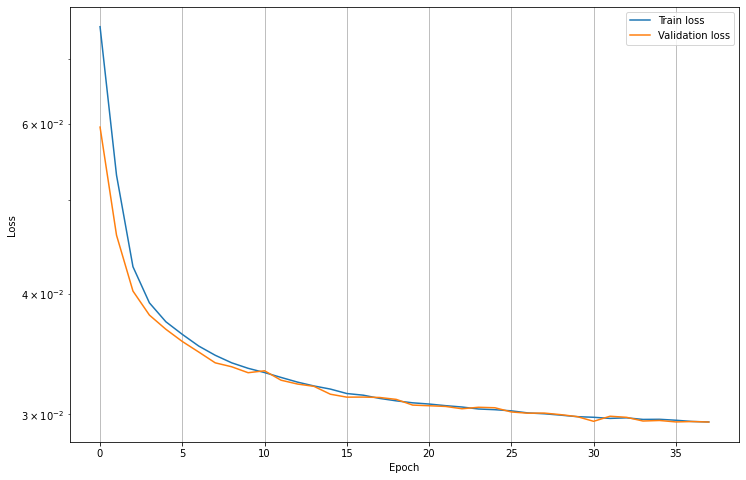

In [15]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Save and load the model

In [16]:
### Save network parameters
### Save the network state
# Save network parameters
torch.save(encoder.state_dict(), 'denoising_encoder_params.pth')
torch.save(decoder.state_dict(), 'denoising_decoder_params.pth')

In [17]:
### Reload the network state
# Load network parameters
encoder.load_state_dict(torch.load('denoising_encoder_params.pth'))
decoder.load_state_dict(torch.load('denoising_decoder_params.pth'))

<All keys matched successfully>

# Network analysis

In [18]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(noise(img))
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1671.87it/s]


In [27]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

# Scatter plot
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

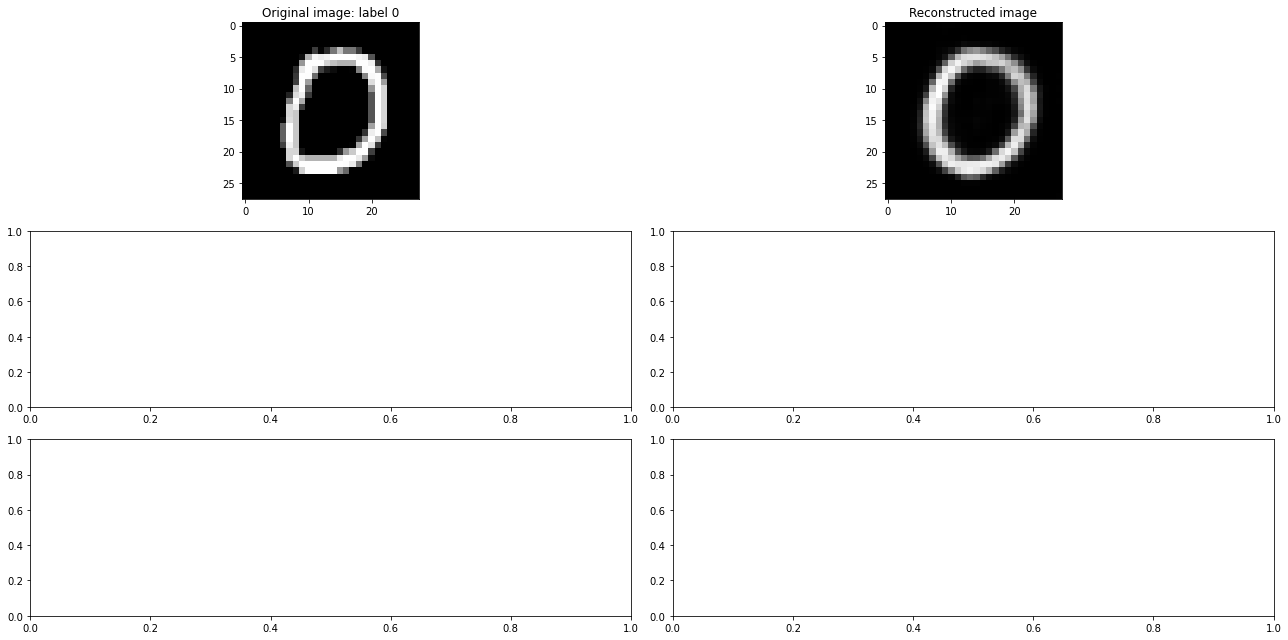

In [28]:
# Reconstruct images
# Get the output of a specific image (the test image at index 0 in this case)
img_indx =10
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]
encoder.eval()
decoder.eval()
with torch.no_grad():
    rec_img  = decoder(encoder(noise(img)))
    
# Plot the reconstructed image
fig, axs = plt.subplots(3, 2, figsize=(18,9))
axs[0,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,0].set_title('Original image: label %d' %label)
axs[0,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,1].set_title('Reconstructed image')
plt.tight_layout()
